In [1]:
!pip install sentencepiece
!pip install wget

In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import json
import pandas as pd
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange
import sentencepiece as spm
import wget

import torch
import torch.nn as nn
import torch.nn.functional as F

vocab 만들기  
https://paul-hyun.github.io/vocab-with-sentencepiece/

In [2]:
# vocab loading
vocab_file = "./kowiki.model"
vocab = spm.SentencePieceProcessor() #subword tokenize(한 단어를 여러 토큰으로 분리)
                                     #단어 변형 및 OOV, 연관성에 대한 문제 해결
vocab.load(vocab_file)

True

- Config

In [3]:
""" configuration json을 읽어들이는 class """
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r', encoding='utf-8') as f:
            config = json.loads(f.read())
            return Config(config)

In [4]:
config = Config({ #config 파일을 활용해 변수 설정 및 수정을 더 간편하게 함.
    "n_dec_vocab": len(vocab),
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_dec_vocab': 8007, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


- Common Class  
참고 ) https://paul-hyun.github.io/transformer-02/

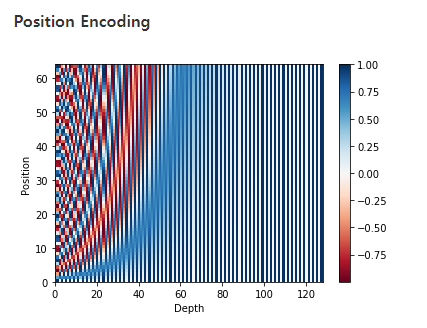
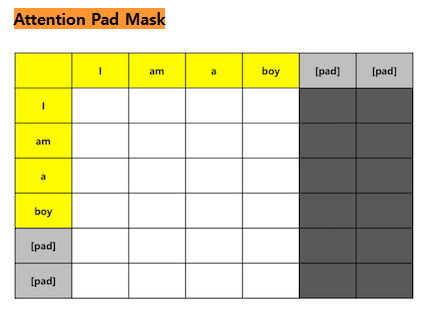
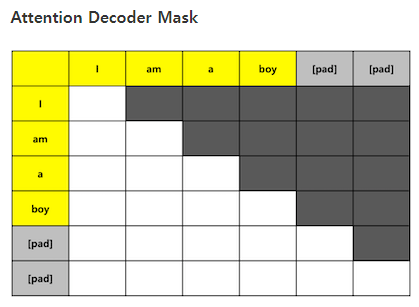
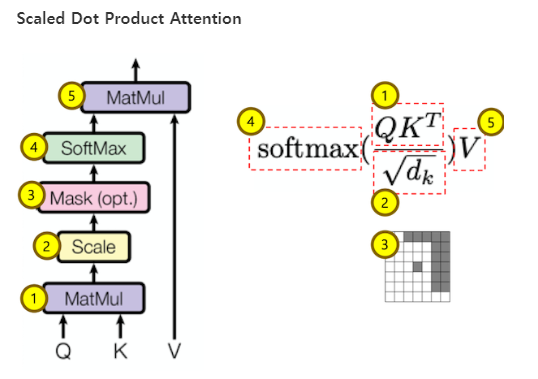
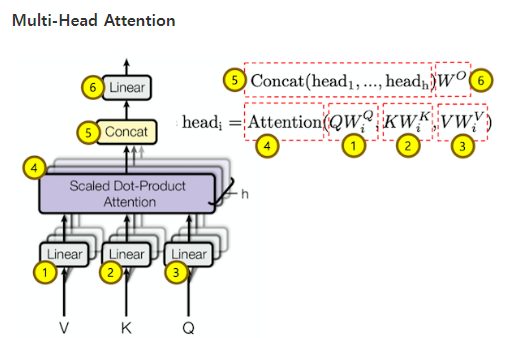
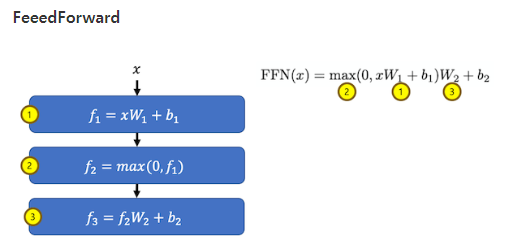

In [5]:
""" sinusoid position encoding """
# sinusoidal positioinal encoding : 포지션끼리 가까우면 내적이 크고 멀면 작아져 거리관계 유추 가능
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)]) #각 position별 hidden index별 angle값
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table


""" attention pad mask """
#attention 시 padding을 제외하기 위한 mask
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    #K의 값 중에 Pad인 부분을 True로 변경한 뒤, len_q / len_k에 맞게 크기 변경
    pad_attn_mask = seq_k.data.eq(i_pad).unsqueeze(1).expand(batch_size, len_q, len_k)  # <pad>
    return pad_attn_mask


""" attention decoder mask """
#다음 단어는 볼 수 없도록 하는 masking
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask

""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob


""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob


""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu #GELU 사용
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

- Decoder  
Transformer Decoder에서 Encoder-Decoder Multi-Head Attention 부분을 제거

In [6]:
""" decoder layer """
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, dec_inputs, self_attn_mask):
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(self_att_outputs)
        ffn_outputs = self.layer_norm3(self_att_outputs + ffn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob

In [7]:
""" decoder """
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs):
        #입력에 대한 position값 구해주기
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
    
        # (bs, n_dec_seq, d_hidn)
        #input embedding + position embedding
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        # (bs, n_dec_seq, n_dec_seq)
        #입력에 대한 attention pad mask 구해주기
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        # (bs, n_dec_seq, n_dec_seq)
        #입력에 대한 decoder attention mask 구해주기
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        # (bs, n_dec_seq, n_dec_seq)
        #둘 중 하나라도 msaking 되어있으면 masking
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)

        self_attn_probs = []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq)
            dec_outputs, self_attn_prob = layer(dec_outputs, dec_self_attn_mask)
            self_attn_probs.append(self_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)]
        return dec_outputs, self_attn_probs

- GPT (Transformer Decoder)

In [8]:
""" gpt """
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.decoder = Decoder(self.config)
    
    def forward(self, dec_inputs):
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)]
        dec_outputs, dec_self_attn_probs = self.decoder(dec_inputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_dec_seq, n_dec_seq)]
        return dec_outputs, dec_self_attn_probs
    
    def save(self, epoch, loss, path):
        torch.save({
            "epoch": epoch,
            "loss": loss,
            "state_dict": self.state_dict()
        }, path)
    
    def load(self, path):
        save = torch.load(path)
        self.load_state_dict(save["state_dict"])
        return save["epoch"], save["loss"]

In [9]:
""" GPT pretrain """
#입력 단어에 대한 다음 단어 예측
class GPTPretrain(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.gpt = GPT(self.config)
        # lm
        self.projection_lm = nn.Linear(self.config.d_hidn, self.config.n_dec_vocab, bias=False)
        self.projection_lm.weight = self.gpt.decoder.dec_emb.weight
    
    def forward(self, dec_inputs):
        # (bs, n_dec_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)]
        dec_outputs, dec_self_attn_probs = self.gpt(dec_inputs)
        # (bs, n_dec_seq, n_dec_vocab)
        logits_lm = self.projection_lm(dec_outputs)
        # (bs, n_dec_seq - 1, n_dec_vocab), (bs, n_output), [(bs, n_head, n_dec_seq, n_dec_seq)]
        return logits_lm[:, :-1, :].contiguous(), dec_self_attn_probs

- Pretrain Data 준비

In [10]:
""" doc별 pretrain 데이터 생성 """
def create_pretrain_instances(doc, n_seq):
    # for [BOS], [EOS]
    max_seq = n_seq - 2
    tgt_seq = max_seq
    
    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i]) # line
        current_length += len(doc[i])
        if i == len(doc) - 1 or current_length >= tgt_seq:
            if 0 < len(current_chunk):
                tokens = []
                for chunk in current_chunk: tokens.extend(chunk)
                tokens = tokens[:tgt_seq]
                if 1 < len(tokens):
                    instance = {
                        "tokens": ["[BOS]"] + tokens + ["[EOS]"],
                    }
                    instances.append(instance)
            current_chunk = []
            current_length = 0
    return instances

In [11]:
""" pretrain 데이터 생성 """
def make_pretrain_data(vocab, in_file, out_file, n_seq):
    line_cnt = 0
    with open(in_file, "r", encoding='utf-8') as in_f:
        for line in in_f:
            line_cnt += 1

    docs = []
    with open(in_file, "r", encoding='utf-8') as f:
        doc = []
        with tqdm_notebook(total=line_cnt, desc=f"Loading") as pbar:
            for i, line in enumerate(f):
                line = line.strip()
                if line == "":
                    if 0 < len(doc):
                        docs.append(doc)
                        doc = []
                        # 메모리 사용량을 줄이기 위해 100,000개만 처리 함
                        if 100000 < len(docs): break
                else:
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
                pbar.update(1)
        if doc:
            docs.append(doc)

    with open(out_file, "w") as out_f:
        with tqdm_notebook(total=len(docs), desc=f"Making") as pbar:
            for i, doc in enumerate(docs):
                instances = create_pretrain_instances(doc, n_seq)
                for instance in instances:
                    out_f.write(json.dumps(instance))
                    out_f.write("\n")
                pbar.update(1)

In [12]:
in_file = "./kowiki.txt"
out_file = "./kowiki_gpt.json"
n_seq = 256

if not os.path.isfile(out_file):
    make_pretrain_data(vocab, in_file, out_file, n_seq)
else:
    print(f"{out_file} exists")

./kowiki_gpt.json exists


- GPT Pretrain Data

In [13]:
""" pretrain 데이터셋 """
class PretrainDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            with tqdm_notebook(total=line_cnt, desc=f"Loading") as pbar:
                for i, line in enumerate(f):
                    instance = json.loads(line)
                    self.sentences.append([vocab.piece_to_id(p) for p in instance["tokens"]])
                    pbar.update(1)
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        return (torch.tensor(self.sentences[item]), torch.tensor(item))

In [14]:
""" pretrain data collate_fn """
def pretrin_collate_fn(inputs):
    dec_inputs, item = list(zip(*inputs))

    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)

    batch = [
        dec_inputs,
        torch.stack(item, dim=0),
    ]
    return batch

In [23]:
""" pretrain 데이터 로더 """
batch_size = 32
dataset = PretrainDataSet(vocab, "./kowiki_gpt.json")
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pretrin_collate_fn)

C:\Users\mining\AppData\Local\Temp/ipykernel_4084/1737125582.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=line_cnt, desc=f"Loading") as pbar:


Loading:   0%|          | 0/239311 [00:00<?, ?it/s]

- Pretrain

In [24]:
""" 모델 epoch 학습 """
def train_epoch(config, epoch, model, criterion_lm, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm_notebook(total=len(train_loader), desc=f"Train({epoch})") as pbar:
        for i, value in enumerate(train_loader):
            dec_inputs, _ = map(lambda v: v.to(config.device), value)
            labels_lm = dec_inputs[:, 1:].contiguous()

            optimizer.zero_grad()
            outputs = model(dec_inputs)
            logits_lm = outputs[0]

            loss_lm = criterion_lm(logits_lm.view(-1, logits_lm.size(2)), labels_lm.view(-1))
            loss = loss_lm 

            loss_val = loss_lm.item()
            losses.append(loss_val)

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [27]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(config)

learning_rate = 5e-5
n_epoch = 5

{'n_dec_vocab': 8007, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cuda')}


In [28]:
model = GPTPretrain(config)

save_pretrain = "./save_gpt_pretrain.pth"
best_epoch, best_loss = 0, 0
if os.path.isfile(save_pretrain):
    best_epoch, best_loss = model.gpt.load(save_pretrain)
    print(f"load pretrain from: {save_pretrain}, epoch={best_epoch}, loss={best_loss}")
    best_epoch += 1

model.to(config.device)

criterion_lm = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
offset = best_epoch
for step in trange(n_epoch, desc="Epoch"):
    epoch = step + offset
    loss = train_epoch(config, epoch, model, criterion_lm, optimizer, train_loader)
    losses.append(loss)
    model.gpt.save(epoch, loss, save_pretrain)

load pretrain from: ./save_gpt_pretrain.pth, epoch=0, loss=8.684824439927464


Epoch:   0%|                                                                                     | 0/5 [00:00<?, ?it/s]C:\Users\mining\AppData\Local\Temp/ipykernel_4084/3591206398.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm_notebook(total=len(train_loader), desc=f"Train({epoch})") as pbar:


Train(1):   0%|          | 0/7479 [00:00<?, ?it/s]

Epoch:  20%|██████████████▌                                                          | 1/5 [17:23<1:09:33, 1043.40s/it]

Train(2):   0%|          | 0/7479 [00:00<?, ?it/s]

Epoch:  40%|██████████████████████████████                                             | 2/5 [34:47<52:12, 1044.05s/it]

Train(3):   0%|          | 0/7479 [00:00<?, ?it/s]

Epoch:  60%|█████████████████████████████████████████████                              | 3/5 [52:12<34:48, 1044.12s/it]

Train(4):   0%|          | 0/7479 [00:00<?, ?it/s]

Epoch:  80%|██████████████████████████████████████████████████████████▍              | 4/5 [1:09:36<17:24, 1044.24s/it]

Train(5):   0%|          | 0/7479 [00:00<?, ?it/s]

Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [1:27:01<00:00, 1044.20s/it]


In [30]:
plt.style.use(['dark_background'])

,loss
0,5.513782
1,5.039537
2,4.724435
3,4.528337
4,4.385542


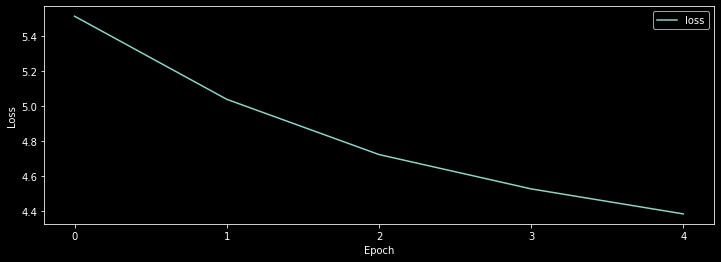

In [32]:
# data
data = {
    "loss": losses
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.legend()
plt.xlabel('Epoch')
plt.xticks([0,1,2,3,4])
plt.ylabel('Loss')
plt.show()